### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
import logging
from pickle import dump
from sklearn.utils import class_weight

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Dataset

In [3]:
dataset_dir = "/kaggle/input/dataset-homework2"

In [4]:
label_mapping = {
    0: "Wish",
    1: "Another",
    2: "Comfortably",
    3: "Money",
    4: "Breathe",
    5: "Time",
    6: "Brain",
    7: "Echoes",
    8: "Wearing",
    9: "Sorrow",
    10: "Hey",
    11: "Shine"
}

In [5]:
X_train_val = np.load(dataset_dir + '/x_train.npy')
y_train_val = np.load(dataset_dir + '/y_train.npy')
X_train_val.shape, y_train_val.shape

((2429, 36, 6), (2429,))

In [6]:
count = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0,
    8: 0,
    9: 0,
    10: 0,
    11: 0
}
for i in range(0,12):
    count[i] = (y_train_val == i).sum()

for i in range(0,12):
    print(str(label_mapping[i]) + ": " + str(count[i]))

Wish: 34
Another: 123
Comfortably: 270
Money: 381
Breathe: 62
Time: 153
Brain: 313
Echoes: 68
Wearing: 120
Sorrow: 777
Hey: 77
Shine: 51


In [7]:
# Split in train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=.05, stratify=y_train_val)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2307, 36, 6), (2307,), (122, 36, 6), (122,))

In [8]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_train.shape, y_val.shape

((2307, 12), (122, 12))

In [9]:
# Reshape in 2d for normalization of features
shape_train = X_train.shape
shape_val = X_val.shape
X_train = X_train.reshape(-1, X_train.shape[-1])
X_val = X_val.reshape(-1, X_val.shape[-1])

# RobustScaler()
scaler = RobustScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

# Reshape in 3d
X_train = X_train.reshape(shape_train)
X_val = X_val.reshape(shape_val)
X_train.shape, X_val.shape

((2307, 36, 6), (122, 36, 6))

### Model metadata

In [10]:
input_shape = (36,6)
classes = 12
batch_size = 64
epochs = 200

### 1D Convolutional Neural Network

In [11]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(512,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.1, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(512, activation='relu')(dropout)
    #classifier = tfkl.Dropout(.1, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(classifier)
    classifier = tfkl.Dropout(.5, seed=seed)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [12]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

2022-12-15 19:41:21.089652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 36, 256)           4864      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 512)           393728    
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656

2022-12-15 19:41:21.090648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 19:41:21.396565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 19:41:21.397479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 19:41:21.398272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 19:41:21.399089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [14]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

2022-12-15 19:41:26.678857: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-12-15 19:41:29.131616: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


37/37 [==============================] - 13s 15ms/step - loss: 3.5563 - accuracy: 0.1725 - val_loss: 2.4177 - val_accuracy: 0.2787
Epoch 2/200
37/37 [==============================] - 0s 8ms/step - loss: 2.5074 - accuracy: 0.3255 - val_loss: 2.1684 - val_accuracy: 0.3607
Epoch 3/200
37/37 [==============================] - 0s 7ms/step - loss: 2.4887 - accuracy: 0.3286 - val_loss: 1.8746 - val_accuracy: 0.3934
Epoch 4/200
37/37 [==============================] - 0s 7ms/step - loss: 2.0002 - accuracy: 0.3775 - val_loss: 1.7489 - val_accuracy: 0.4016
Epoch 5/200
37/37 [==============================] - 0s 7ms/step - loss: 1.8851 - accuracy: 0.3988 - val_loss: 1.7047 - val_accuracy: 0.4180
Epoch 6/200
37/37 [==============================] - 0s 5ms/step - loss: 1.8154 - accuracy: 0.4239 - val_loss: 1.5672 - val_accuracy: 0.5000
Epoch 7/200
37/37 [==============================] - 0s 5ms/step - loss: 1.7507 - accuracy: 0.4556 - val_loss: 1.4651 - val_accuracy: 0.5410
Epoch 8/200
37/37 [====

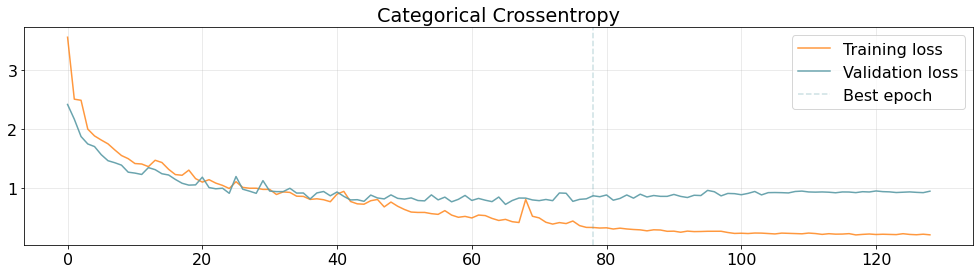

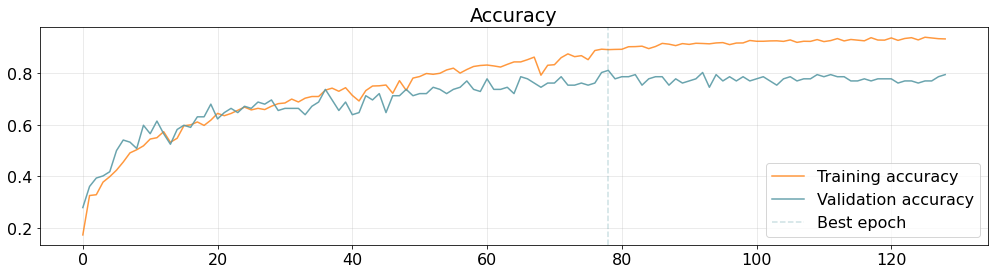

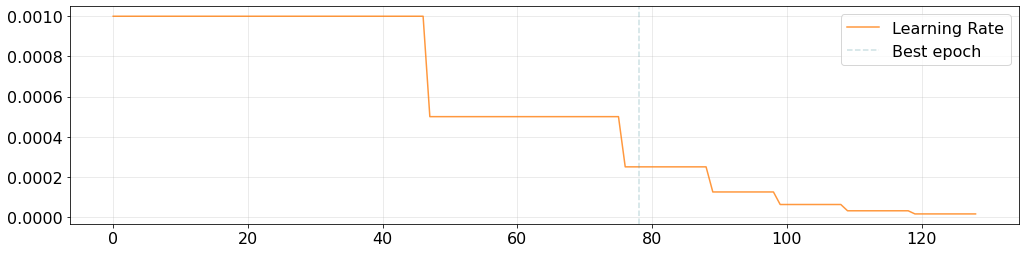

In [15]:
# Show plots
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [16]:
# Predict the validation set with the 1DCNN
predictions = model.predict(X_val)
predictions.shape

(122, 12)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.8115
Precision: 0.8542
Recall: 0.7507
F1: 0.781


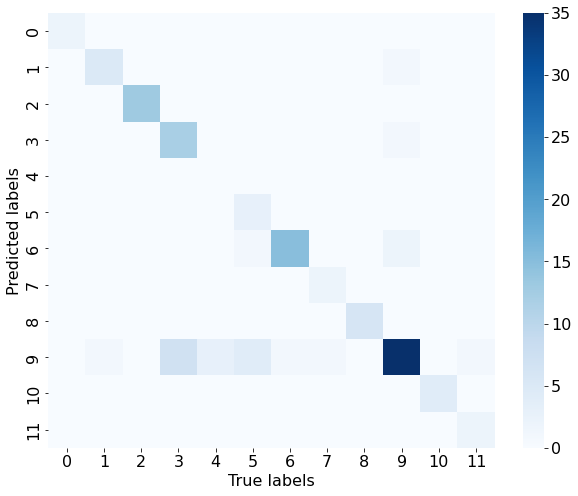

In [17]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [18]:
# Save the model
model.save("1DCNN")

2022-12-15 19:42:10.276856: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [19]:
# Save the scaler
dump(scaler, open('scaler.pkl', 'wb'))

In [20]:
# Load the model
#model = tfk.models.load_model()